# Store Sales Demand Forecast

### Introduction

The dataset used in this code was obtained from [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv). Due to github filesize limit, dataset not checked into the repo. Download to local first.  

* Starts with forecasting sales for ONE family with holidays factor: bread and bakery. 
* Add oil regressor
* Add another onpromotion regressor
* Expand to multiple families forecast 

In [452]:
# !pip install prophet
# !pip install duckdb
# !pip install seaborn

### Import libraries

In [453]:
import numpy as np
import pandas as pd
import duckdb
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 #"axes.edgecolor": "lightgrey",
 #"axes.facecolor": "None",
 "axes.grid": False,
 #"axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 #"figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 #"patch.edgecolor": "w",
 #"patch.force_edgecolor": True,
 #"text.color": "dimgrey",
 "xtick.bottom": False,
 #"xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 #"ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

### Function: Check for null values

In [454]:
def missing_data(input_data):
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

### Function: Check Model Accuracy (Mean Absolute Percentage Error (MAPE))

In [455]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Data Prep

In [489]:
df = pd.read_csv('data/train.csv')
df.head
df.onpromotion.unique()

array([  0,   3,   5,   1,  56,  20,  19,   2,   4,  18,  17,  12,   6,
         7,  10,   9,  50,   8,  16,  42,  51,  13,  15,  47,  21,  40,
        37,  54,  24,  58,  22,  59,  11,  45,  25,  55,  26,  43,  35,
        14,  28,  46,  36,  32,  53,  57,  27,  39,  41,  30,  29,  49,
        23,  48,  44,  38,  31,  52,  33,  34,  61,  60, 116,  86,  73,
       113, 102,  68, 104,  93,  70,  92, 121,  72, 178, 174, 161, 118,
       105, 172, 163, 167, 142, 154, 133, 180, 181, 173, 165, 168, 186,
       140, 149, 145, 169, 188,  62,  84, 111,  65, 107,  63, 101,  87,
       125,  94, 114, 171, 153, 170, 166, 141, 155, 179, 192, 131, 147,
       151, 189,  79,  74, 110,  64,  67,  99, 123, 157, 117, 150, 182,
       162, 160, 194, 135, 190,  69, 108,  89, 126, 156, 103, 146, 132,
       177, 164, 176, 112,  75, 109,  91, 128, 175, 187, 148, 137, 184,
       196, 144, 158, 119, 106,  66, 100,  90, 120, 115,  98, 159, 152,
       185, 139, 143,  80, 124,  71, 134, 193,  78,  88, 122, 13

In the demo, ignore store_nbr factor, assume all sales come from one store. However, you can build models for each individual store. 
* filter out store_nbr 1 sales: df[df['store_nbt'] == 1], 
* check how many unique stores: df.store_nbr.unique()

In [457]:
##-- check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


### Assigning the approprate data types

In [458]:
##-- standardize column names
df.columns = df.columns.str.replace(' ', '_').str.lower()

##--convert date to datetime
df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [459]:
##-- check minimum and maximum date values
(min_date, max_date) = duckdb.query("select min(date) as min_date, max(date) as max_date from df").fetchone()
(min_date, max_date)

(datetime.datetime(2013, 1, 1, 0, 0), datetime.datetime(2017, 8, 15, 0, 0))

###  Aggregate the data to the family and sales daily levels
* This will provide daily demand data for each product family

In [460]:
sql = """
select date, family, sum(sales) sales, max(onpromotion) onpromotion
from df
group by 1,2
order by 2,1
"""
agg_df = duckdb.query(sql).fetchdf()
agg_df.head()

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.00,0
1,2013-01-02,AUTOMOTIVE,255.00,0
2,2013-01-03,AUTOMOTIVE,161.00,0
3,2013-01-04,AUTOMOTIVE,169.00,0
4,2013-01-05,AUTOMOTIVE,342.00,0


In [461]:
##-- check the data
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   family       55572 non-null  object        
 2   sales        55572 non-null  float64       
 3   onpromotion  55572 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ MB


### creating a pivot table for the aggregated data

In [462]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.46,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


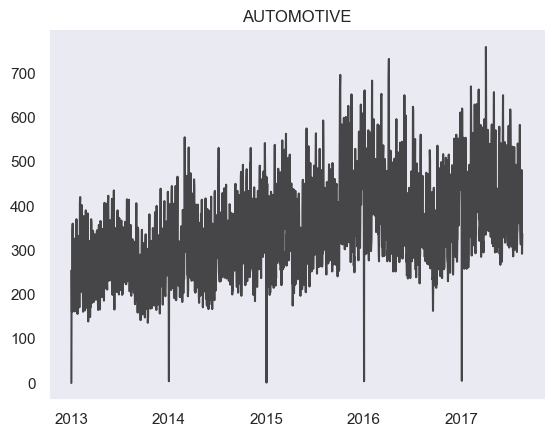

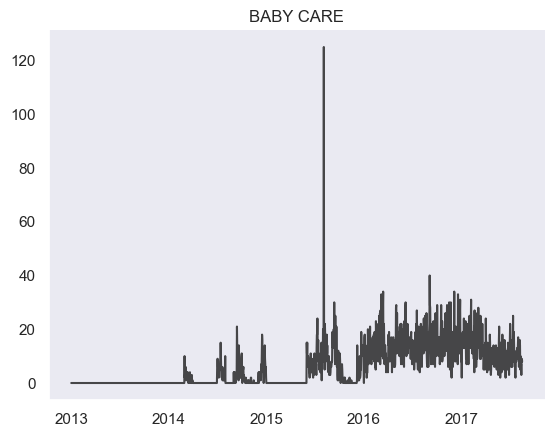

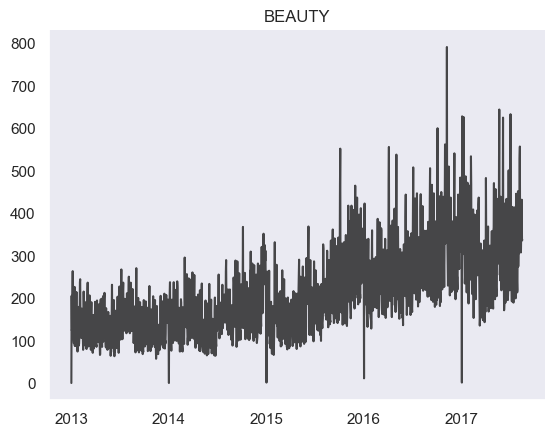

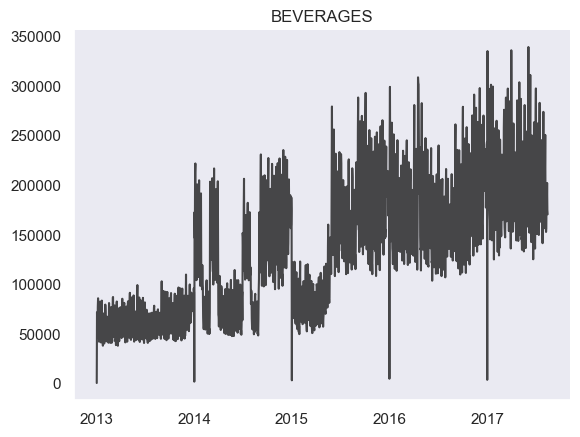

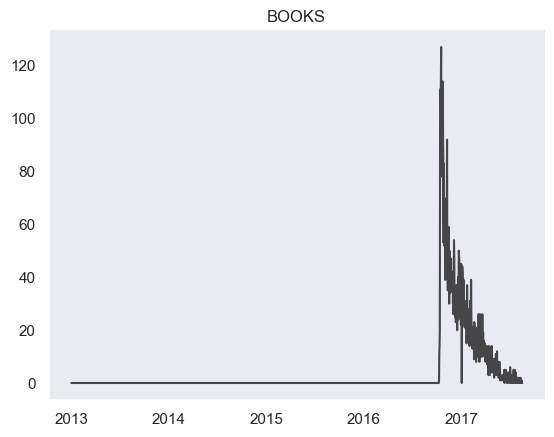

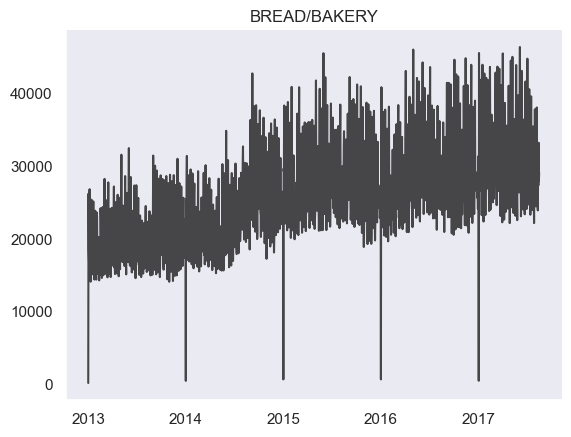

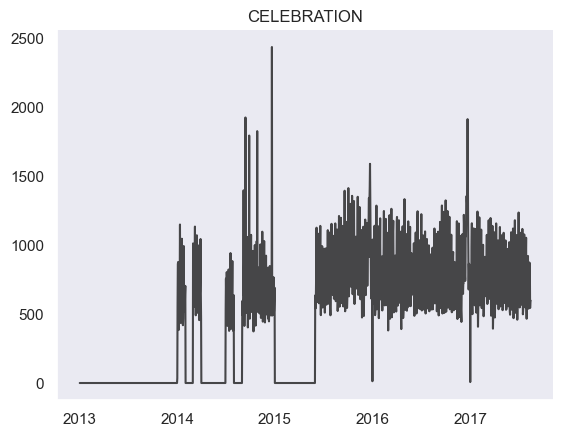

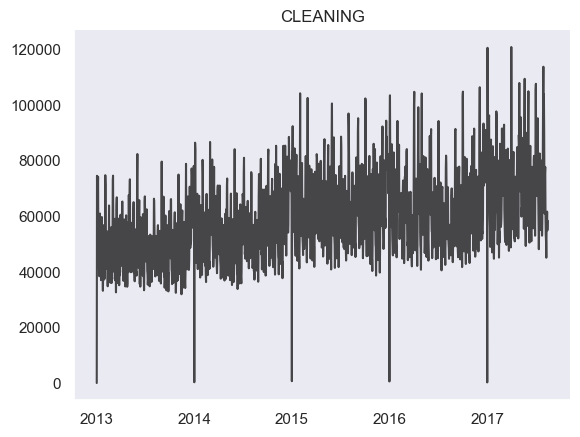

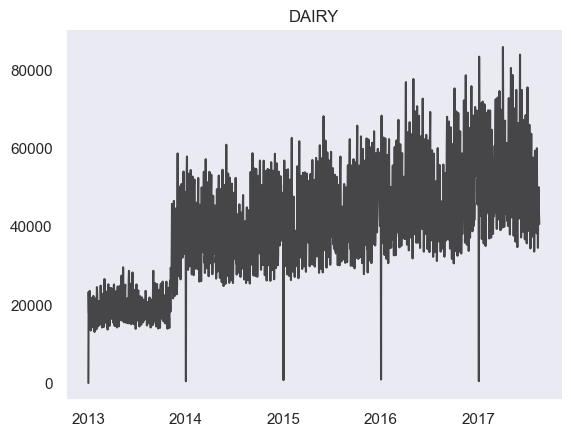

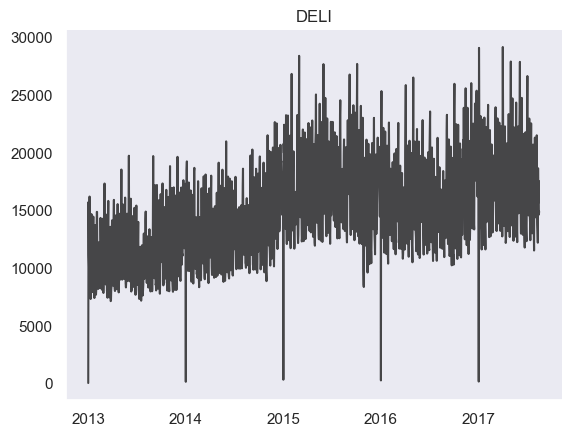

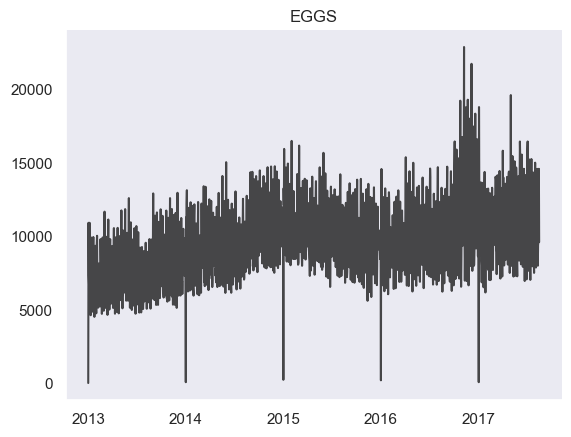

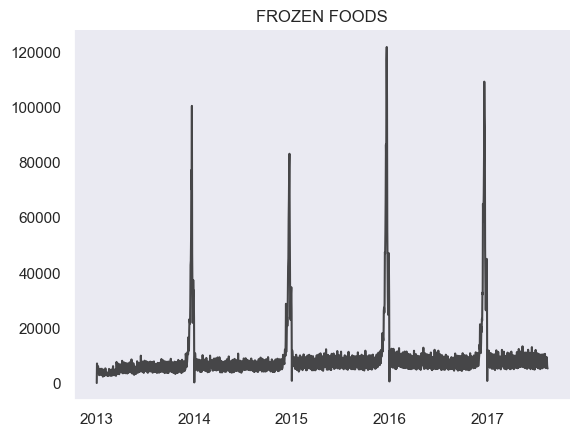

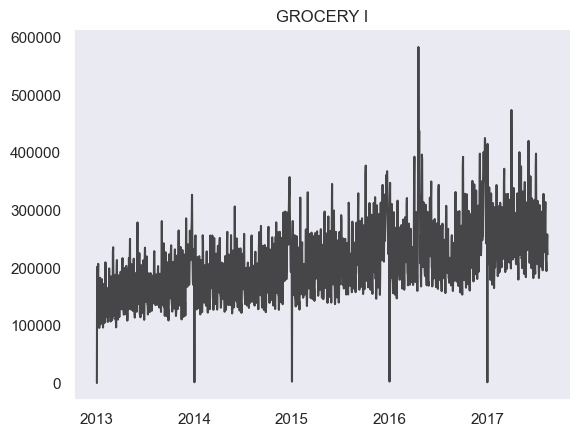

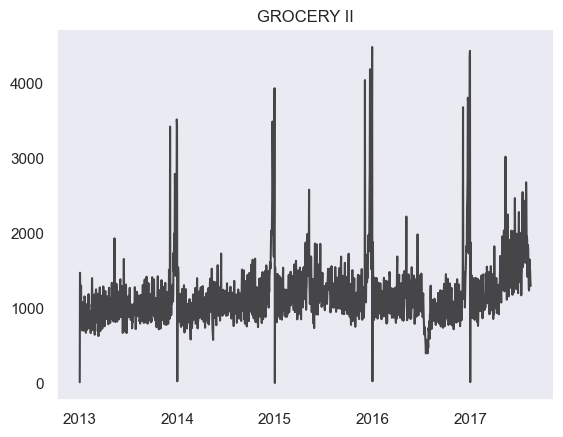

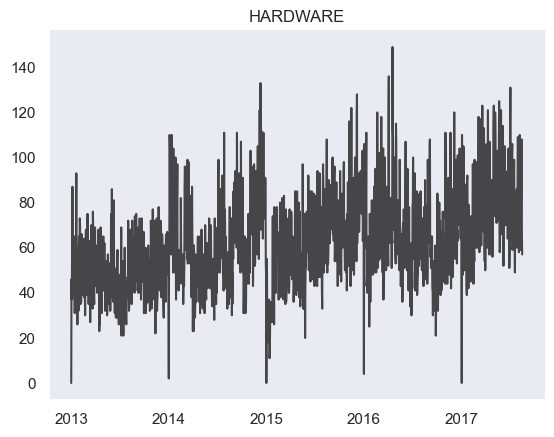

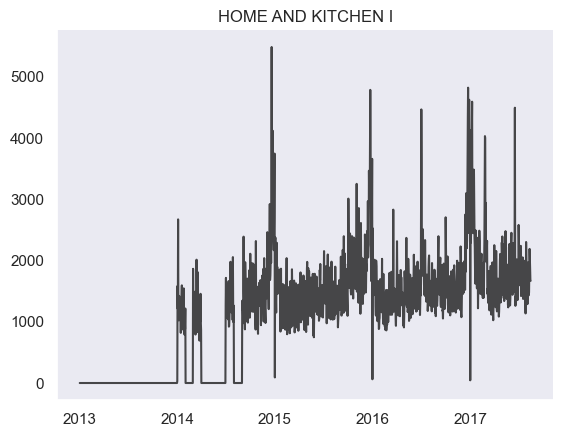

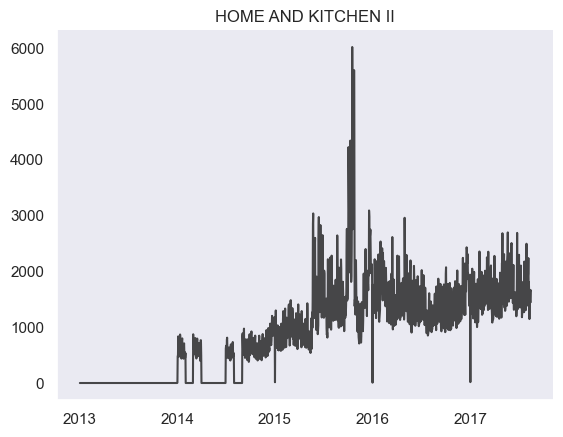

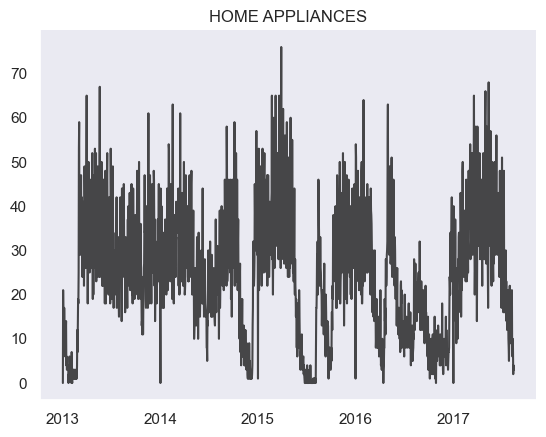

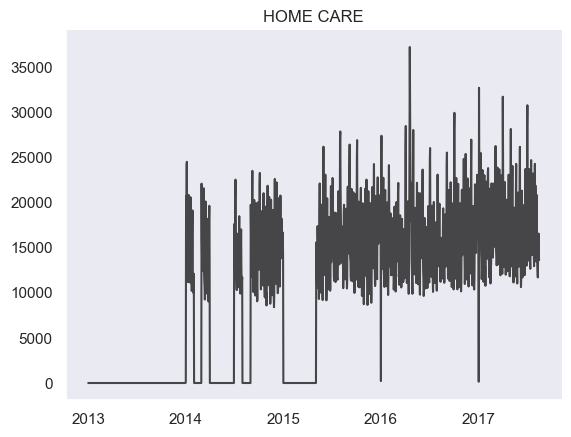

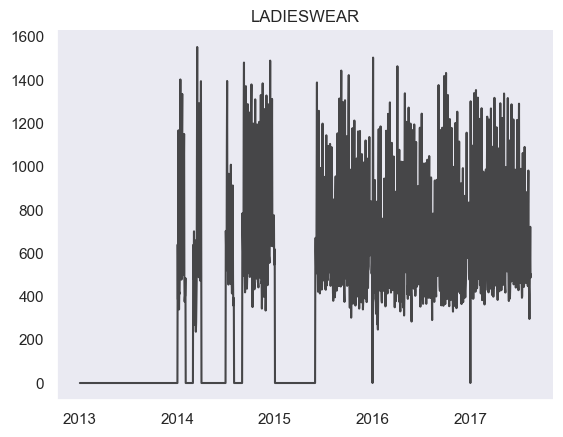

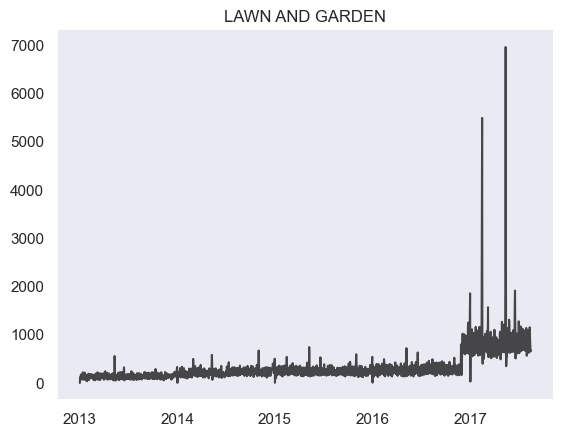

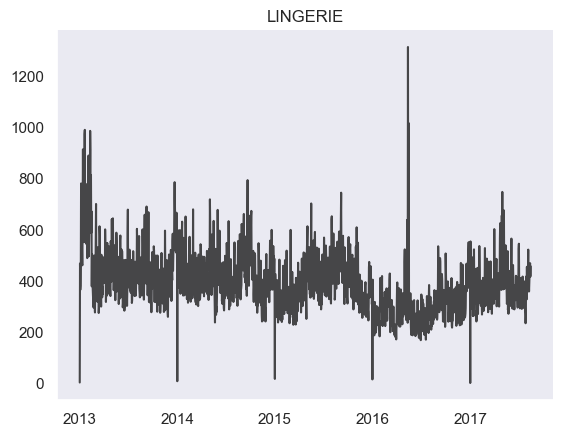

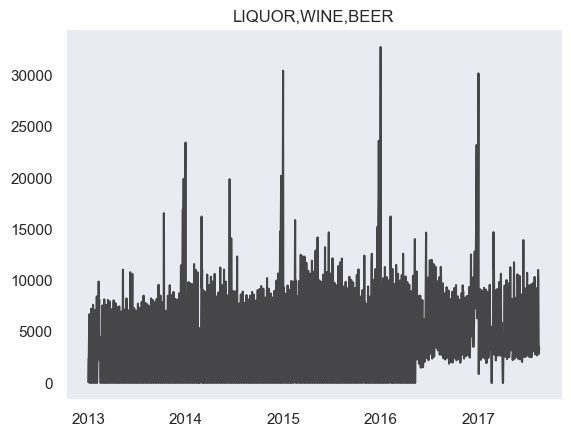

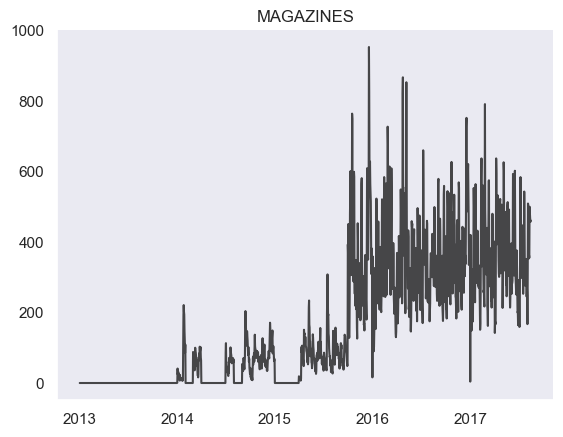

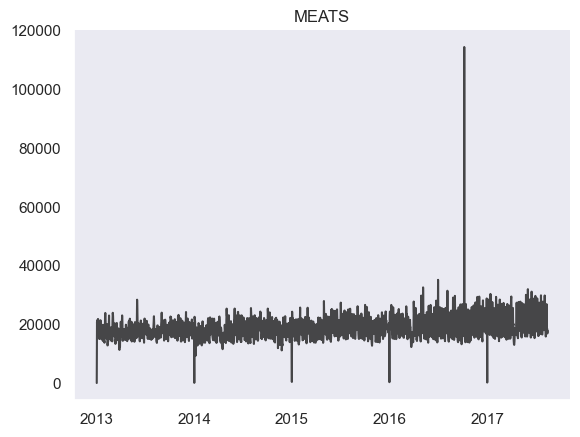

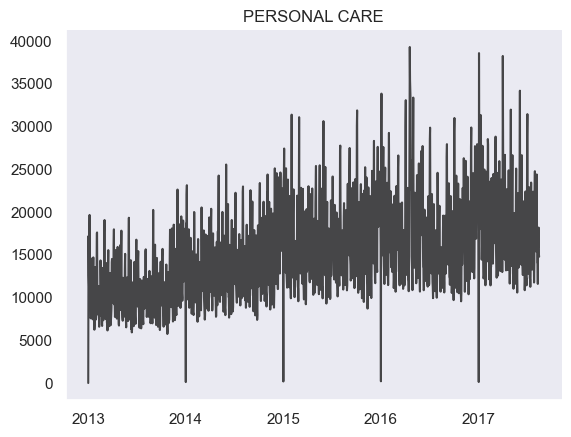

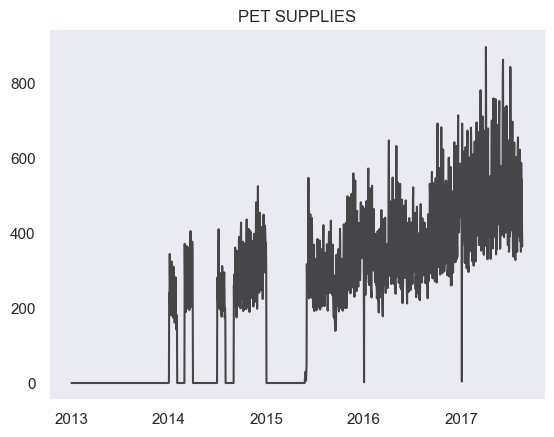

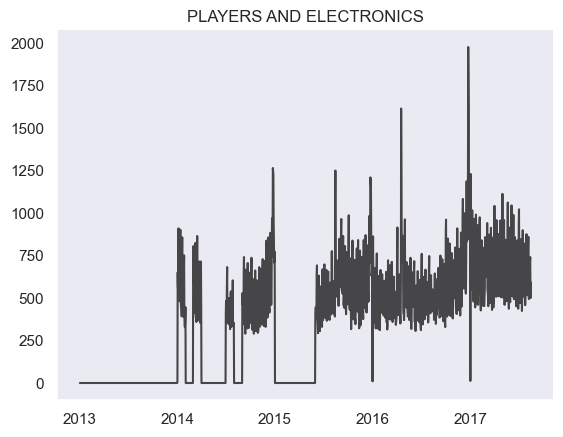

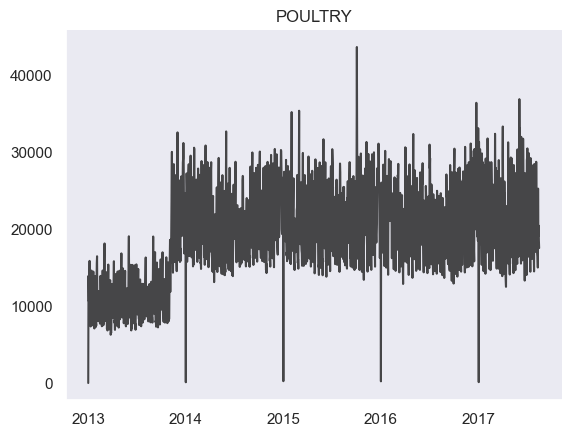

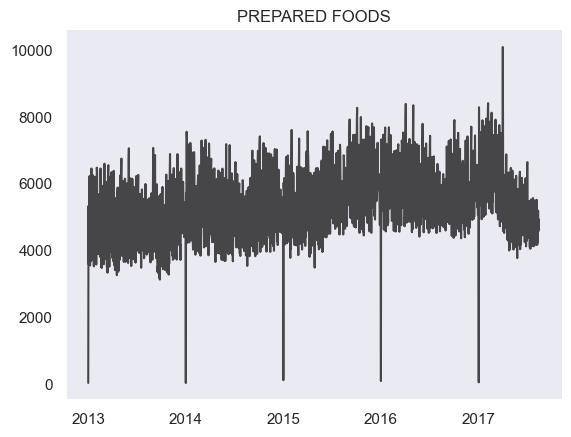

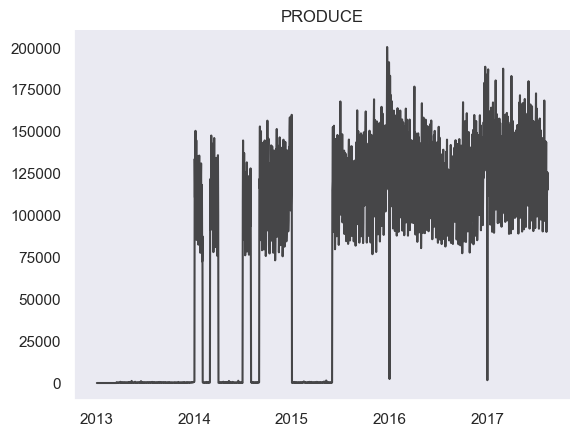

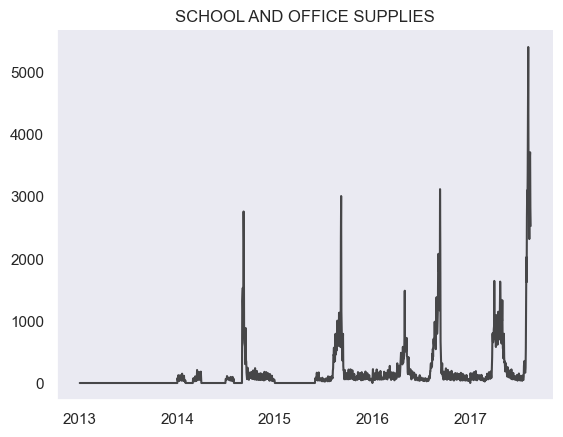

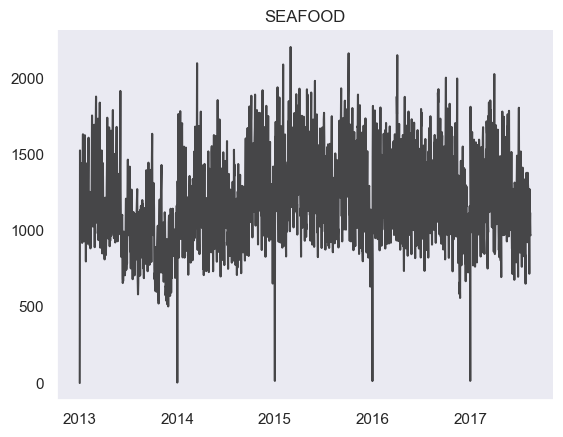

In [463]:
##-- visualizing the data

for column in total_sales_df.columns:
    plt.plot(total_sales_df[column], color='black', alpha=0.7)
    plt.title(column)
    plt.show()

### Data Cleaning:

* Check for missing values
* Eliminate low sales volume products that cannot be accurately predicted.
* Remove products with insufficient historical data. Visual inspection or counting daily '0' sales can identify these.
* Remove outliers using z-score calculations. This will eliminate outliers close to 0 sales for all product categories.
* Filter data to only include 08/15/15 - 08/15/17 date range. Check if additional data needs removal after this filter. If data looks clean, proceed with modeling pipeline.

In [464]:
##-- checking missing data
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


In [465]:
##-- only keep products with avg daily sales greater than $1000

# get all columns
all_columns = total_sales_df.columns

#Keep products with avg daily sales greater than $1000
keep_columns = total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') >= 1000]

# remove products with avg daily sales less than $1000
exclusion_columns =  all_columns.difference(keep_columns)

print("Dropping "+ str(len(exclusion_columns))+" columns due to insufficient data volume.")
total_sales_df = total_sales_df[keep_columns]
total_sales_df.head()

Dropping 15 columns due to insufficient data volume.


family,BEVERAGES,BREAD/BAKERY,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HOME AND KITCHEN I,HOME CARE,"LIQUOR,WINE,BEER",MEATS,PERSONAL CARE,POULTRY,PREPARED FOODS,PRODUCE,SEAFOOD
date,,,,,,,,,,,,,,,,,,
2013-01-01,810.00,180.59,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,105.00,110.80,25.00,42.64,37.85,0.00,0.00
2013-01-02,72092.00,26246.32,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,0.00,0.00,2411.00,20871.46,17204.00,13975.88,5338.11,0.00,1526.75
2013-01-03,52105.00,18456.48,55893.00,18001.00,11172.46,7358.00,4760.81,144878.00,1048.00,0.00,0.00,2476.00,16597.40,12568.00,10674.39,3591.39,0.00,1094.31
2013-01-04,54167.00,16721.97,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,0.00,0.00,4796.00,21625.96,11303.00,10772.52,4472.97,0.00,1293.12
2013-01-05,77818.00,22367.76,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,0.00,0.00,6715.00,20879.09,16819.00,13475.01,5830.07,0.00,1245.64


In [466]:
##-- Filter data to only include 08/15/15 - 08/15/17 date range
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

### Eliminate low sales volume products that cannot be accurately predicted.

* Group categories by data volume, as higher volume improves forecasting accuracy
* Higher volume results in less noise and lower error bars
* Grouping allows visualizing forecasts on similar scales for comparison

### Category Grouping

In [467]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis='rows').sort_values()
low, mid = np.percentile(avg_daily_sales, [33,66])

In [468]:
avg_daily_sales, low, mid

(family
 SEAFOOD                1241.14
 GROCERY II             1246.87
 HOME AND KITCHEN I     1707.09
 LIQUOR,WINE,BEER       5157.08
 PREPARED FOODS         5643.84
 FROZEN FOODS           9828.31
 EGGS                  10069.28
 HOME CARE             15734.36
 DELI                  16222.12
 PERSONAL CARE         17091.29
 MEATS                 19328.74
 POULTRY               21032.82
 BREAD/BAKERY          28520.34
 DAIRY                 47031.14
 CLEANING              64159.21
 PRODUCE              123782.00
 BEVERAGES            177660.02
 GROCERY I            240048.18
 dtype: float64,
 9975.300514164013,
 22680.070769943453)

In [469]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index
low_vol_columns,mid_vol_columns,high_vol_columns

(['SEAFOOD',
  'GROCERY II',
  'HOME AND KITCHEN I',
  'LIQUOR,WINE,BEER',
  'PREPARED FOODS',
  'FROZEN FOODS'],
 Index(['EGGS', 'HOME CARE', 'DELI', 'PERSONAL CARE', 'MEATS', 'POULTRY'], dtype='object', name='family'),
 Index(['BREAD/BAKERY', 'DAIRY', 'CLEANING', 'PRODUCE', 'BEVERAGES',
        'GROCERY I'],
       dtype='object', name='family'))

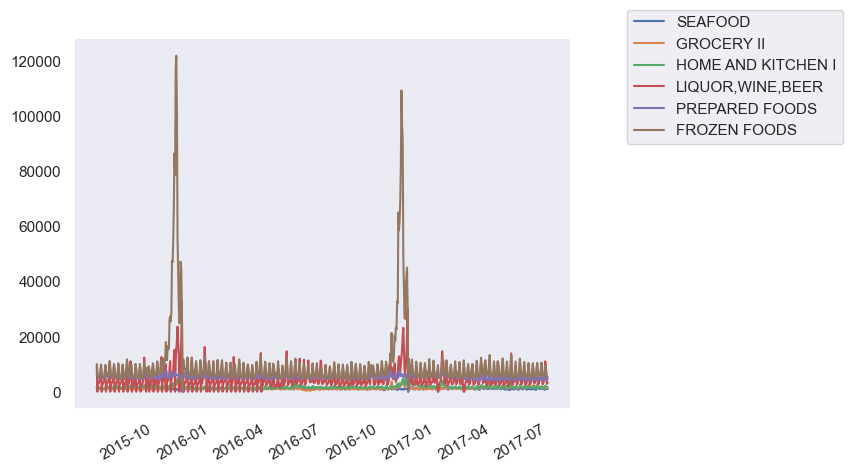

In [470]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

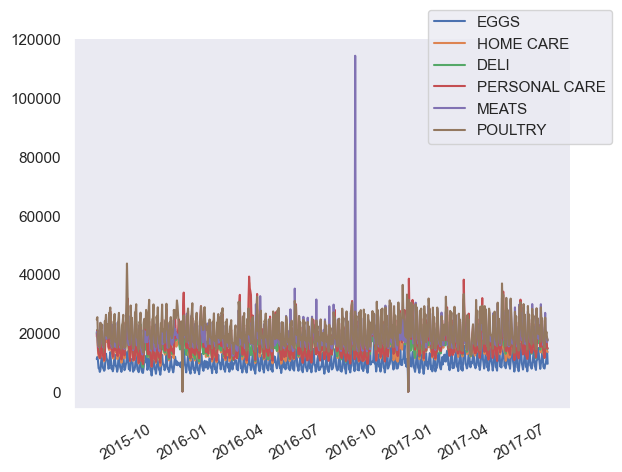

In [471]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

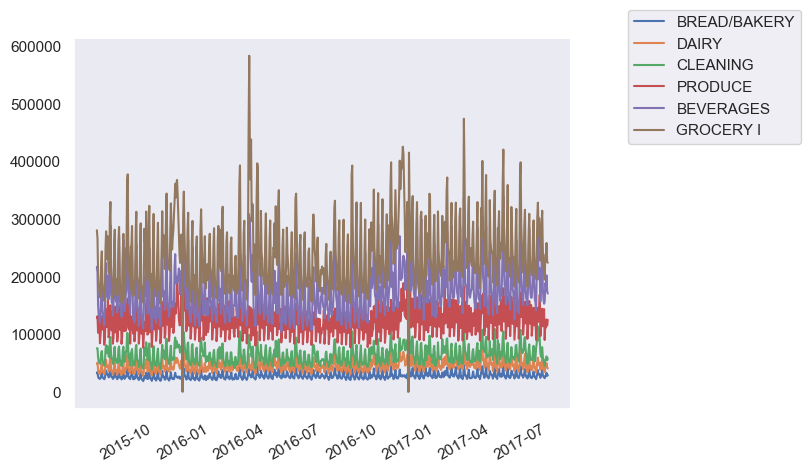

In [472]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

We observe here that bread/bakery is one of the items with a high volume metric. We will focus on forecasting sales for this particular item to see how it performs.

### Testing with "Bread/Bakery"

In [473]:
#setting variables
feature = 'BREAD/BAKERY'
prediction_days = 30

In [474]:
df = total_sales_df[[feature]].reset_index()
df.head()

family,date,BREAD/BAKERY
0,2015-08-15,32509.91
1,2015-08-16,34851.88
2,2015-08-17,26361.77
3,2015-08-18,23915.95
4,2015-08-19,23995.15


#### holiday info

In [475]:
# read holidays data
holidays_df = pd.read_csv('data/holidays_events.csv')

# only keep national holidays
national_holidays = holidays_df[(holidays_df['locale'] == 'National') & (holidays_df['type'] == 'Holiday')]
national_holidays['lower_window'] = -2
national_holidays['upper_window'] = 1
holidays = national_holidays[['date','description','lower_window', 'upper_window']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

/var/folders/37/ynryj5js4px7jpw5mhyc9pgr0000gn/T/ipykernel_38727/1693635373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_holidays['lower_window'] = -2
/var/folders/37/ynryj5js4px7jpw5mhyc9pgr0000gn/T/ipykernel_38727/1693635373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_holidays['upper_window'] = 1


,ds,holiday,lower_window,upper_window
14,2012-08-10,Primer Grito de Independencia,-2,1
19,2012-10-09,Independencia de Guayaquil,-2,1
21,2012-11-02,Dia de Difuntos,-2,1
22,2012-11-03,Independencia de Cuenca,-2,1
37,2012-12-25,Navidad,-2,1
41,2013-01-01,Primer dia del ano,-2,1
44,2013-02-11,Carnaval,-2,1
45,2013-02-12,Carnaval,-2,1
51,2013-04-29,Viernes Santo,-2,1
52,2013-05-01,Dia del Trabajo,-2,1


https://pypi.org/project/holidays/

In [476]:
#Variables

# forecast_start_dt = date(2017,7,1) #data set ends on (2017,8,15)
forecast_start_date = pd.Timestamp('2017-07-01')

### Predicting sales with Facebook Prophet Model

In [477]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})

# Convert ds to datetime and y to numberic if not done yet
# df_copy['ds'] = pd.to_datetime(df_copy['ds'])
# df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet(holidays=holidays)

# m.add_country_holidays(country_name='US')

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing


In [478]:
##-- checking predicted values
predicted_df.head(10)

,ds,yhat
684,2017-07-01,34530.43
685,2017-07-02,40499.08
686,2017-07-03,30066.21
687,2017-07-04,27549.06
688,2017-07-05,28159.90
689,2017-07-06,24906.31
690,2017-07-07,27781.06
691,2017-07-08,34553.76
692,2017-07-09,40522.41
693,2017-07-10,30089.54


<b> variable considerations for prophet model: </b> growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

In [479]:
##-- comparing true and predicted values
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

predicted_df

,ds,yhat,ytrue
0,2017-07-01,34530.43,38304.17
1,2017-07-02,40499.08,44839.79
2,2017-07-03,30066.21,32696.44
3,2017-07-04,27549.06,28806.21
4,2017-07-05,28159.90,28769.54
5,2017-07-06,24906.31,24758.21
6,2017-07-07,27781.06,28049.34
7,2017-07-08,34553.76,32995.15
8,2017-07-09,40522.41,40633.64
9,2017-07-10,30089.54,29713.90


In [294]:
##-- checking accuracy
100-mape(predicted_df['ytrue'], predicted_df['yhat'])

93.23824005494791

### Cross Validation with Prophet
Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [295]:
m = Prophet(holidays=holidays)
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/42 [00:00<?, ?it/s]

16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:34 - cmdstanpy - INFO - Chain [1] start processing
16:14:34 - cmdstanpy - INFO - Chain [1] done processing
16:14:34 - cmdstanpy - INFO - Chain [1] start processing
16:14:34 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:36 - cmdstanpy - INFO - Chain [1] done processing
16:14:36 - cmdstanpy - INFO - Chain [1] start processing
16:14:36 - cmdstanpy - INFO - Chain [1] done processing
16:14:36 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1]

In [ ]:
#total_sales_df[total_sales_df['PRODUCE']<10000]

In [296]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,6082930.25,2466.36,1762.04,0.06,0.05,0.06,0.78
1,4 days,5496835.57,2344.53,1684.79,0.06,0.05,0.06,0.79
2,5 days,4780295.08,2186.39,1706.08,0.06,0.05,0.06,0.76
3,6 days,4900738.18,2213.76,1715.46,0.06,0.05,0.06,0.74
4,7 days,4567190.96,2137.10,1726.39,0.07,0.06,0.06,0.71
5,8 days,4626395.03,2150.91,1717.30,0.07,0.05,0.06,0.72
6,9 days,5364481.72,2316.14,1866.03,0.07,0.06,0.07,0.68
7,10 days,5814987.32,2411.43,1897.78,0.07,0.06,0.07,0.70
8,11 days,6732274.68,2594.66,1991.75,0.08,0.06,0.07,0.68
9,12 days,6444766.14,2538.65,1897.35,0.07,0.05,0.07,0.71


df_p gives you the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.

In [254]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
119,2017-01-02,31221.25,28175.76,34090.06,45621.16,2017-01-01,31.56,False
120,2017-01-03,25461.95,22509.89,28457.79,35916.70,2017-01-01,29.11,False
208,2017-04-01,34712.12,31626.21,38058.40,45561.27,2017-03-02,23.81,False
116,2016-12-30,24633.77,21476.90,27418.99,31058.87,2016-12-02,20.69,False
59,2016-11-02,23424.70,20312.90,26549.85,29341.76,2016-10-03,20.17,False
121,2017-01-04,25828.67,22813.26,28688.42,32084.67,2017-01-01,19.50,False
93,2016-12-06,24991.01,21983.93,28066.98,30523.18,2016-12-02,18.12,False
112,2016-12-26,23921.60,20945.07,26902.48,29190.66,2016-12-02,18.05,False
70,2016-11-13,37031.57,33911.75,40066.32,44902.40,2016-11-02,17.53,False
28,2016-10-02,36899.77,33986.98,39851.54,44698.51,2016-09-03,17.45,False


In [255]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2016-09-04,37300.61,34478.98,40061.29,41518.69,2016-09-03,10.16,False
1,2016-09-05,27813.53,24803.05,31008.31,31015.78,2016-09-03,10.32,False
2,2016-09-06,25469.11,22752.00,28593.89,28444.62,2016-09-03,10.46,False
3,2016-09-07,25808.01,22710.80,28733.33,26954.62,2016-09-03,4.25,False
4,2016-09-08,22931.54,19965.97,25958.24,22999.11,2016-09-03,0.29,False


#### Optimizing for "BREAD/BAKERY" feature. What that means is... <b> lets hypertune this model! </b>

In [297]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - ERROR - Chain [1] error: error d

In [ ]:
print(tuning_results)

In [ ]:
tuning_results.sort_values('rmse')

In [ ]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

In [ ]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

In [ ]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'],
           holidays=holidays)


In [ ]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

In [ ]:
100-mape(predicted_df['ytrue'], predicted_df['yhat'])

### Add additional regressor - Oil price

In [480]:
# still using df created for BREAD/BAKERY before 
df.head()

family,date,BREAD/BAKERY
0,2015-08-15,32509.91
1,2015-08-16,34851.88
2,2015-08-17,26361.77
3,2015-08-18,23915.95
4,2015-08-19,23995.15


In [481]:
# read in oil price
oil_df = pd.read_csv('data/oil.csv')
# convert to datetime
oil_df['date'] = pd.to_datetime(oil_df['date'])
# rename columns
oil_df.columns=['date', 'oil_price']

In [482]:
sql = """
select df.date as ds, "BREAD/BAKERY" as y, oil_price from df
left join oil_df on df.date = oil_df.date
"""
sales_oil_df = duckdb.query(sql).fetchdf()
# Fill NaN values in the 'Sales' column with the previous non-null value
sales_oil_df['oil_price'].fillna(method='ffill', inplace=True)
sales_oil_df.head()

/var/folders/37/ynryj5js4px7jpw5mhyc9pgr0000gn/T/ipykernel_38727/3864427118.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sales_oil_df['oil_price'].fillna(method='ffill', inplace=True)


,ds,y,oil_price
0,2015-08-17,26361.77,41.93
1,2015-08-18,23915.95,42.58
2,2015-08-19,23995.15,40.75
3,2015-08-20,22592.65,41.00
4,2015-08-24,26750.30,38.22


In [483]:
#PROPHET MODEL

df_copy = sales_oil_df.copy()

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet(holidays=holidays)
m.add_regressor('oil_price')
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
future['oil_price'] = 48.81
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]
predicted_df.head()

23:24:09 - cmdstanpy - INFO - Chain [1] start processing
23:24:10 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat
684,2017-07-01,34547.98
685,2017-07-02,40519.78
686,2017-07-03,30283.15
687,2017-07-04,27755.00
688,2017-07-05,28379.47


In [484]:
##-- comparing true and predicted values
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

predicted_df

,ds,yhat,ytrue
0,2017-07-01,34547.98,38304.17
1,2017-07-02,40519.78,44839.79
2,2017-07-03,30283.15,32696.44
3,2017-07-04,27755.00,28806.21
4,2017-07-05,28379.47,28769.54
5,2017-07-06,25110.92,24758.21
6,2017-07-07,27993.49,28049.34
7,2017-07-08,34588.76,32995.15
8,2017-07-09,40560.55,40633.64
9,2017-07-10,30323.93,29713.90


In [485]:
##-- checking accuracy
100-mape(predicted_df['ytrue'], predicted_df['yhat'])

93.2613850228309

### Add another regressor - onpromotion

In [490]:
# onpromotion: how many products of that category were on promotion on that day
promotion_df = agg_df[agg_df['family'] == feature]
sql="""
select sales_oil_df.*, onpromotion
from sales_oil_df 
left join promotion_df on sales_oil_df.ds = promotion_df.date
"""
sale_oil_promotion_df = duckdb.query(sql).fetchdf()
sale_oil_promotion_df.head()

,ds,y,oil_price,onpromotion
0,2015-08-15,32509.91,48.81,4
1,2015-08-17,26361.77,41.93,6
2,2015-08-18,23915.95,42.58,6
3,2015-08-19,23995.15,40.75,5
4,2015-08-20,22592.65,41.00,4
